In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re


In [2]:
df = pd.read_csv("Survey Kepuasan SMK_Train.csv", delimiter= ";")
df

,Survey,Label
0,Sangat baik dalam menjelaskan materi dan juga ...,positif
1,walaupun yang mengajar selalu asisten tetapi m...,positif
2,"Walaupun, Pelajaran ini merupakan kelas besar ...",negatif
3,sebaiknya tidak usah menyuruh maju satu persat...,negatif
4,"semoga lebih baik kedepannya,",positif
...,...,...
2874,"sudah sangat baik, sabar dan telaten dalam men...",positif
2875,sarannya lebih baik dijelaskan secara langsung...,negatif
2876,cara untuk mengajarnya lebih di tingkatkan kem...,positif
2877,"sangat bagus mendatangkan para narasumber hebat,",positif


In [3]:
df['Label'].value_counts()

Label
positif    1792
negatif    1087
Name: count, dtype: int64

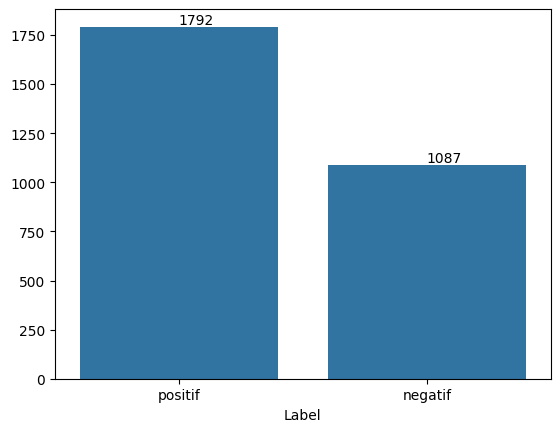

In [4]:
sns.barplot(
    x = df['Label'].value_counts().index,
    y = df['Label'].value_counts().values
)
for i in range(len(df['Label'].value_counts().index)):
    plt.text(i, df['Label'].value_counts().values[i], df['Label'].value_counts().values[i], va = "bottom" )

Text(0.5, 1.0, 'Presentase Nilai Sentimen')

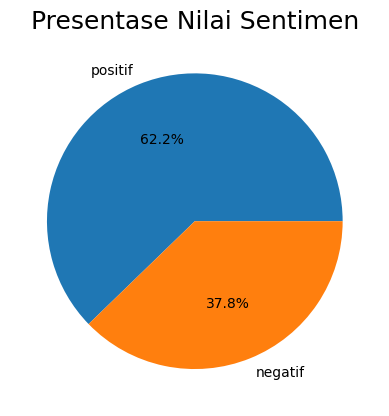

In [5]:
    
    plt.pie(
        df['Label'].value_counts(),
        autopct= "%1.1f%%",
        labels= df['Label'].value_counts().index
    )
    plt.title("Presentase Nilai Sentimen", fontsize = 18)

(np.float64(-0.5), np.float64(799.5), np.float64(399.5), np.float64(-0.5))

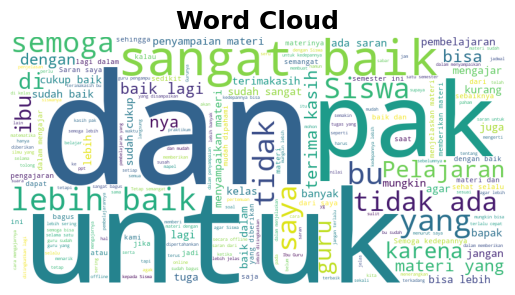

In [6]:
from wordcloud import WordCloud
text_gabung = " ".join(df['Survey'])
wordcloud = WordCloud(
    width= 800,
    height= 400,
    background_color= "white"
).generate(text_gabung)
plt.imshow(wordcloud)
plt.title("Word Cloud", fontsize = 18, fontweight = "bold")
plt.axis("Off")

## TFIDF

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(ngram_range = (1,2))
X = vectorizer.fit_transform(df['Survey'])
y = df['Label']

In [8]:
X

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 54343 stored elements and shape (2879, 16071)>

In [9]:
y

0       positif
1       positif
2       negatif
3       negatif
4       positif
         ...   
2874    positif
2875    negatif
2876    positif
2877    positif
2878    positif
Name: Label, Length: 2879, dtype: object

## Scatter plot


In [10]:
from sklearn.decomposition import PCA
pca = PCA(n_components= 2)

X_pca = pca.fit_transform(X)
X_pca


array([[ 0.10472941,  0.1544354 ],
       [ 0.02776926,  0.07974559],
       [-0.05539126, -0.02620048],
       ...,
       [-0.0258321 , -0.06190214],
       [-0.03375403,  0.03814776],
       [ 0.12945589,  0.15714167]], shape=(2879, 2))

Text(0.5, 1.0, 'Persebaran Berdasarkan Sentiment')

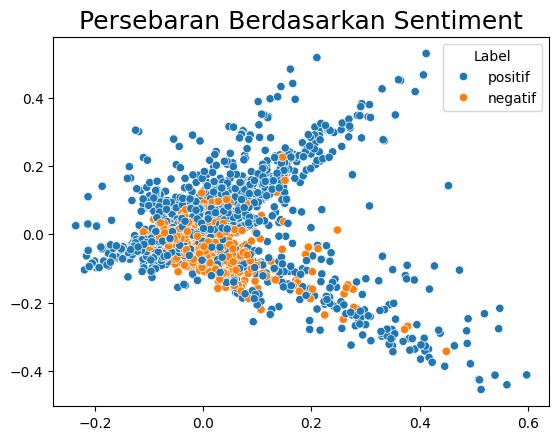

In [11]:
sns.scatterplot(
    x = X_pca[:, 0],
    y = X_pca[:, 1],
    hue = y
)
plt.title("Persebaran Berdasarkan Sentiment", fontsize = 18)

# SPLIT

In [12]:
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size= 0.2, random_state= 42
)

In [13]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(2303, 16071)
(2303,)
(576, 16071)
(576,)


# MODELLING

In [14]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score

## REGLOC

In [101]:
from sklearn.linear_model import LogisticRegression
param = {
    "class_weight" : ["balanced"],
    "C" : [0.01,0.1,1,5,10]
}
model_regloc = GridSearchCV(LogisticRegression(), param, cv = 5)
model_regloc.fit(X_train, y_train)

# Score
regloc_train = model_regloc.score(X_train, y_train)
regloc_test = model_regloc.score(X_test, y_test)

print("Score Training set : ", regloc_train)
print("Score Testing set : ", regloc_test)
print("Best Parameter : ", model_regloc.best_params_)
print("Best Estimator : ", model_regloc.best_estimator_)

# regloc_size, train_size, test_size = learning_curve(model_regloc, X_train, y_train, cv = 5)
# train_mean = np.mean(train_size, axis= 1)
# test_mean = np.mean(test_size,  axis = 1)

# plt.plot(regloc_size, train_mean, label = "Training Score")
# plt.plot(regloc_size, test_mean, label = "Testing Score")
# plt.legend()

Score Training set :  0.9930525401650022
Score Testing set :  0.890625
Best Parameter :  {'C': 10, 'class_weight': 'balanced'}
Best Estimator :  LogisticRegression(C=10, class_weight='balanced')


Accuracy Score : 0.890625

Classification Report :  
               precision    recall  f1-score   support

     negatif       0.83      0.89      0.86       213
     positif       0.93      0.89      0.91       363

    accuracy                           0.89       576
   macro avg       0.88      0.89      0.88       576
weighted avg       0.89      0.89      0.89       576


F1 SCORE :  [0.86 0.91]
[[189  24]
 [ 39 324]]


<Axes: >

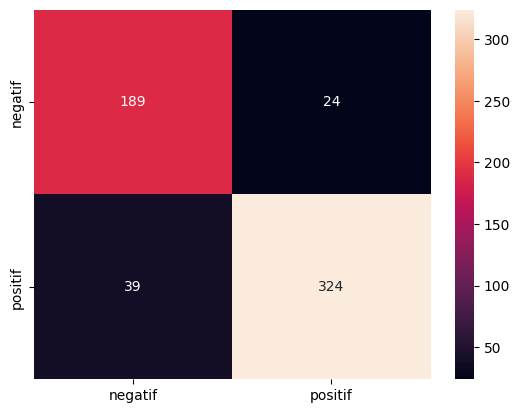

In [103]:
# Evaluasi
y_pred = model_regloc.predict(X_test)
regloc_acc = accuracy_score(y_test, y_pred)
print("Accuracy Score :", regloc_acc)
print()
print("Classification Report : ", "\n", classification_report(y_test, y_pred))
print()
regloc_f1 = f1_score(y_test, y_pred, average= None).round(2)
print("F1 SCORE : ",regloc_f1)
print(confusion_matrix(y_test, y_pred))
sns.heatmap(
    confusion_matrix(y_test, y_pred),
    annot= True,
    fmt= "d",
    xticklabels= ["negatif", "positif"],
    yticklabels= ["negatif", "positif"]
)



## KNN

In [65]:
from sklearn.neighbors import KNeighborsClassifier
param = {
    "n_neighbors" : [5,7,9,11,13,15,17],
    "weights" : ["uniform", 'distance']
}
model_knn = GridSearchCV(KNeighborsClassifier(), param, cv = 5)
model_knn.fit(X_train, y_train)

# Score
knn_train = model_knn.score(X_train, y_train)
knn_test = model_knn.score(X_test, y_test)

print("Score Training set : ", knn_train)
print("Score Testing set : ", knn_test)
print("Best Parameter : ", model_knn.best_params_)
print("Best Estimator : ", model_knn.best_estimator_)

# knn_size, train_size, test_size = learning_curve(model_knn, X_train, y_train, cv = 5)
# train_mean = np.mean(train_size, axis= 1)
# test_mean = np.mean(test_size,  axis = 1)

# plt.plot(knn_size, train_mean, label = "Training Score")
# plt.plot(knn_size, test_mean, label = "Testing Score")
# plt.legend()

Score Training set :  0.9995657837603127
Score Testing set :  0.7951388888888888
Best Parameter :  {'n_neighbors': 15, 'weights': 'distance'}
Best Estimator :  KNeighborsClassifier(n_neighbors=15, weights='distance')


Accuracy Score : 0.7951388888888888

Classification Report :  
               precision    recall  f1-score   support

     negatif       0.84      0.55      0.67       213
     positif       0.78      0.94      0.85       363

    accuracy                           0.80       576
   macro avg       0.81      0.75      0.76       576
weighted avg       0.80      0.80      0.78       576


F1 SCORE :  [0.67 0.85]


<Axes: >

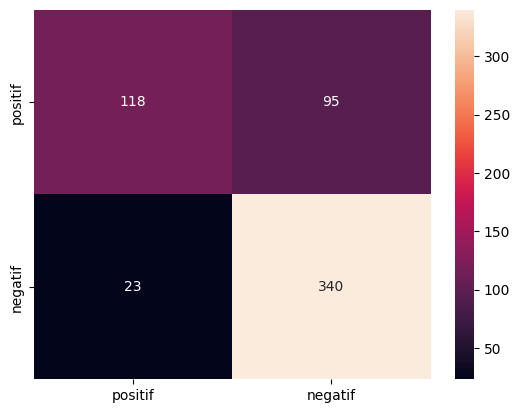

In [66]:
# Evaluasi
y_pred = model_knn.predict(X_test)
knn_acc = accuracy_score(y_test, y_pred)
print("Accuracy Score :", knn_acc)
print()
print("Classification Report : ", "\n", classification_report(y_test, y_pred))
print()
knn_f1 = f1_score(y_test, y_pred, average= None).round(2)
print("F1 SCORE : ",knn_f1)

sns.heatmap(
    confusion_matrix(y_test, y_pred),
    annot= True,
    fmt= "d",
    xticklabels= ["negatif", "positif"],
    yticklabels= ["negatif", "positif"]
)



## NAIVE

In [67]:
from sklearn.naive_bayes import MultinomialNB
param = {
    "alpha" : [0.01, 0.1, 1,5,10],
    'fit_prior' : [True, False]
}
model_nb = GridSearchCV(MultinomialNB(), param, cv = 5)
model_nb.fit(X_train, y_train)

# Score
nb_train = model_nb.score(X_train, y_train)
nb_test = model_nb.score(X_test, y_test)

print("Score Training set : ", nb_train)
print("Score Testing set : ", nb_test)
print("Best Parameter : ", model_nb.best_params_)
print("Best Estimator : ", model_nb.best_estimator_)

# nb_size, train_size, test_size = learning_curve(model_nb, X_train, y_train, cv = 5)
# train_mean = np.mean(train_size, axis= 1)
# test_mean = np.mean(test_size,  axis = 1)

# plt.plot(nb_size, train_mean, label = "Training Score")
# plt.plot(nb_size, test_mean, label = "Testing Score")
# plt.legend()

Score Training set :  0.9882761615284411
Score Testing set :  0.8802083333333334
Best Parameter :  {'alpha': 0.1, 'fit_prior': True}
Best Estimator :  MultinomialNB(alpha=0.1)


Accuracy Score : 0.8802083333333334

Classification Report :  
               precision    recall  f1-score   support

     negatif       0.83      0.85      0.84       213
     positif       0.91      0.90      0.90       363

    accuracy                           0.88       576
   macro avg       0.87      0.87      0.87       576
weighted avg       0.88      0.88      0.88       576


F1 SCORE :  [0.84 0.9 ]


<Axes: >

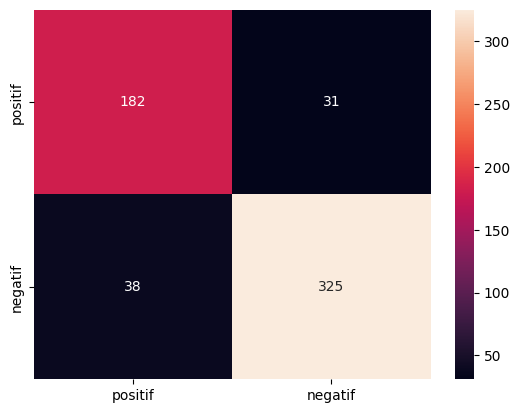

In [68]:
# Evaluasi
y_pred = model_nb.predict(X_test)
nb_acc = accuracy_score(y_test, y_pred)
print("Accuracy Score :", nb_acc)
print()
print("Classification Report : ", "\n", classification_report(y_test, y_pred))
print()
nb_f1 = f1_score(y_test, y_pred, average= None).round(2)
print("F1 SCORE : ",nb_f1)

sns.heatmap(
    confusion_matrix(y_test, y_pred),
    annot= True,
    fmt= "d",
    xticklabels= ["negatif", "positif"],
    yticklabels= ["negatif", "positif"]
)



## Random Forest

In [71]:
from sklearn.ensemble import RandomForestClassifier
param = {
    "class_weight" : ["balanced"]
    "n_estimators" : [200,250,300],
    "max_depth" : [50,60,70,80,90,100]
}
model_rf = GridSearchCV(RandomForestClassifier(), param, cv = 5)
model_rf.fit(X_train, y_train)

# Score
rf_train = model_rf.score(X_train, y_train)
rf_test = model_rf.score(X_test, y_test)

print("Score Training set : ", rf_train)
print("Score Testing set : ", rf_test)
print("Best Parameter : ", model_rf.best_params_)
print("Best Estimator : ", model_rf.best_estimator_)

# rf_size, train_size, test_size = learning_curve(model_rf, X_train, y_train, cv = 5)
# train_mean = np.mean(train_size, axis= 1)
# test_mean = np.mean(test_size,  axis = 1)

# plt.plot(rf_size, train_mean, label = "Training Score")
# plt.plot(rf_size, test_mean, label = "Testing Score")
# plt.legend()

C:\Users\SKOMDA TECH\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
100 fits failed out of a total of 350.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
50 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\SKOMDA TECH\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\SKOMDA TECH\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
    ~~~~~~~~~~~~~~~~~~~~~~

Score Training set :  0.9817629179331308
Score Testing set :  0.8628472222222222
Best Parameter :  {'max_depth': 70, 'n_estimators': 200}
Best Estimator :  RandomForestClassifier(max_depth=70, n_estimators=200)


Accuracy Score : 0.8628472222222222

Classification Report :  
               precision    recall  f1-score   support

     negatif       0.86      0.75      0.80       213
     positif       0.86      0.93      0.90       363

    accuracy                           0.86       576
   macro avg       0.86      0.84      0.85       576
weighted avg       0.86      0.86      0.86       576


F1 SCORE :  [0.8 0.9]


<Axes: >

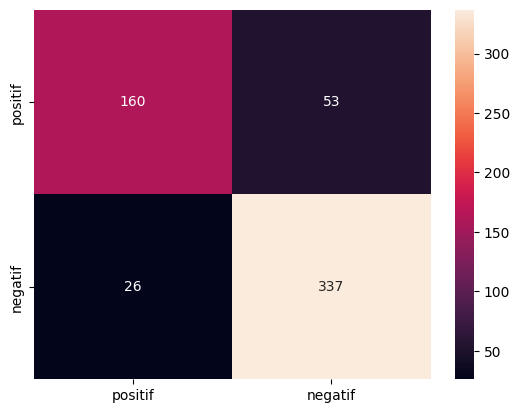

In [72]:
# Evaluasi
y_pred = model_rf.predict(X_test)
rf_acc = accuracy_score(y_test, y_pred)
print("Accuracy Score :", rf_acc)
print()
print("Classification Report : ", "\n", classification_report(y_test, y_pred))
print()
rf_f1 = f1_score(y_test, y_pred, average= None).round(2)
print("F1 SCORE : ",rf_f1)

sns.heatmap(
    confusion_matrix(y_test, y_pred),
    annot= True,
    fmt= "d",
    xticklabels= ["negatif", "positif"],
    yticklabels= ["negatif", "positif"]
)



## SVC

In [73]:
from sklearn.svm import SVC
param = {
    "class_weight" : ["balanced"],
    "C" : [0.01, 0.1, 1,5,10,100],
    "gamma" : [0.01,0.1,1,5,10]
    
    
}
model_svc = GridSearchCV(SVC(), param, cv = 5)
model_svc.fit(X_train, y_train)

# Score
svc_train = model_svc.score(X_train, y_train)
svc_test = model_svc.score(X_test, y_test)

print("Score Training set : ", svc_train)
print("Score Testing set : ", svc_test)

# svc_size, train_size, test_size = learning_curve(model_svc, X_train, y_train, cv = 5)
# train_mean = np.mean(train_size, axis= 1)
# test_mean = np.mean(test_size,  axis = 1)

# plt.plot(svc_size, train_mean, label = "Training Score")
# plt.plot(svc_size, test_mean, label = "Testing Score")
# plt.legend()

Score Training set :  0.9765523230568823
Score Testing set :  0.8940972222222222


Accuracy Score : 0.8940972222222222

Classification Report :  
               precision    recall  f1-score   support

     negatif       0.82      0.91      0.86       213
     positif       0.94      0.89      0.91       363

    accuracy                           0.89       576
   macro avg       0.88      0.90      0.89       576
weighted avg       0.90      0.89      0.90       576


F1 SCORE :  [0.86 0.91]


<Axes: >

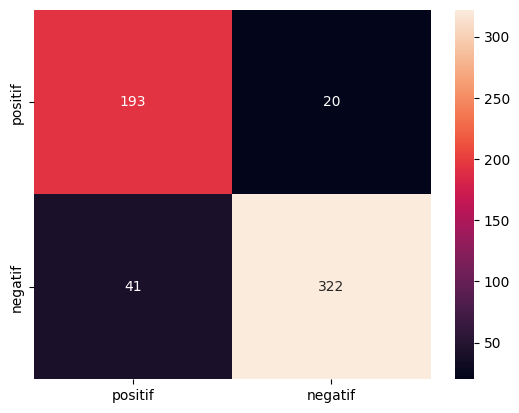

In [74]:
# Evaluasi
y_pred = model_svc.predict(X_test)
svc_acc = accuracy_score(y_test, y_pred)
print("Accuracy Score :", svc_acc)
print()
print("Classification Report : ", "\n", classification_report(y_test, y_pred))
print()
svc_f1 = f1_score(y_test, y_pred, average= None).round(2)
print("F1 SCORE : ",svc_f1)

sns.heatmap(
    confusion_matrix(y_test, y_pred),
    annot= True,
    fmt= "d",
    xticklabels= ["negatif", "positif"],
    yticklabels= ["negatif", "positif"]
)



# EVALUASI

## ACCURACY

In [75]:
accuracy_df = pd.DataFrame({
    "Model" : ["LOGISTIC REGRESSION", "KNN", "NAIVE BAYES", "RANDOM FOREST", "SVC"],
    "Accuracy" : [regloc_acc, knn_acc, nb_acc, rf_acc, svc_acc]
})
accuracy_df

,Model,Accuracy
0,LOGISTIC REGRESSION,0.890625
1,KNN,0.795139
2,NAIVE BAYES,0.880208
3,RANDOM FOREST,0.862847
4,SVC,0.894097


C:\Users\SKOMDA TECH\AppData\Local\Temp\ipykernel_26152\2812573477.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


Text(0.5, 1.0, 'ACCURACY SCORE')

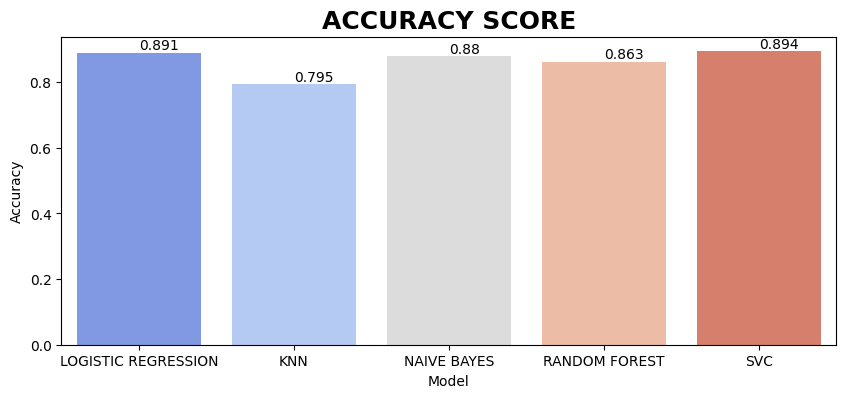

In [84]:
plt.figure(figsize= (10,4))
sns.barplot(
    x = accuracy_df['Model'],
    y = accuracy_df['Accuracy'],
    palette= "coolwarm"
)
for i in range(len(accuracy_df['Model'])):
    plt.text(i, accuracy_df['Accuracy'][i].round(3), accuracy_df['Accuracy'][i].round(3), va = "bottom" )
plt.title("ACCURACY SCORE", fontsize = 18, fontweight = "bold")

## SCORE

In [77]:
score_df = pd.DataFrame({
    "Model" : ["LOGISTIC REGRESSION", "KNN", "NAIVE BAYES", "RANDOM FOREST", "SVC"],
    "Train" : [regloc_train, knn_train, nb_train, rf_train, svc_train],
    "Test" : [regloc_test, knn_test, nb_test, rf_test, svc_test]
})
score_df

,Model,Train,Test
0,LOGISTIC REGRESSION,0.993053,0.890625
1,KNN,0.999566,0.795139
2,NAIVE BAYES,0.988276,0.880208
3,RANDOM FOREST,0.981763,0.862847
4,SVC,0.976552,0.894097


Text(0.5, 1.0, 'SCORE TRAIN Vs TEST')

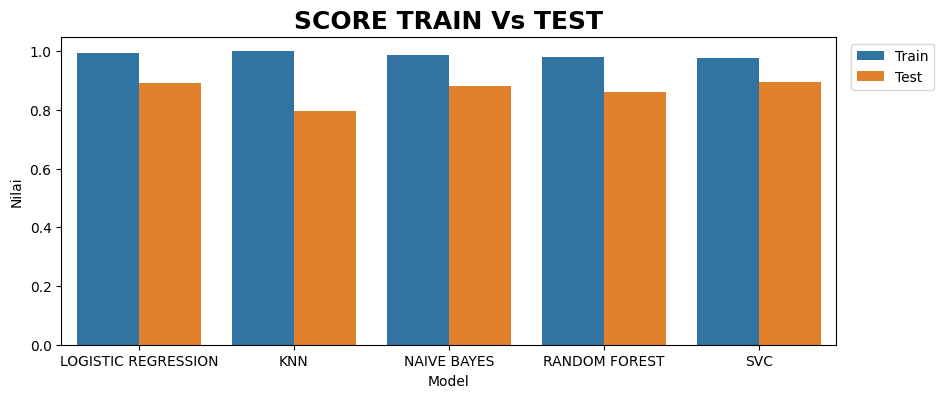

In [78]:
plt.figure(figsize= (10,4))
sns.barplot(
    data = score_df.melt(id_vars="Model", var_name= "Score", value_name= "Nilai"),
    x = "Model",
    y = "Nilai",
    hue = "Score"
)
plt.legend(bbox_to_anchor = (1.01,1))
plt.title("SCORE TRAIN Vs TEST", fontsize = 18, fontweight = "bold")

## F1 SCORE

In [85]:
f1_df = pd.DataFrame({
    "Model" : ["LOGISTIC REGRESSION", "KNN", "NAIVE BAYES", "RANDOM FOREST", "SVC"],
    "Negatif" : [regloc_f1[0], knn_f1[0], nb_f1[0], rf_f1[0], svc_f1[0]],
    "Positif" : [regloc_f1[1], knn_f1[1], nb_f1[1], rf_f1[1], svc_f1[1]]
})
f1_df

,Model,Negatif,Positif
0,LOGISTIC REGRESSION,0.86,0.91
1,KNN,0.67,0.85
2,NAIVE BAYES,0.84,0.90
3,RANDOM FOREST,0.80,0.90
4,SVC,0.86,0.91


Text(0.5, 1.0, 'SCORE F1')

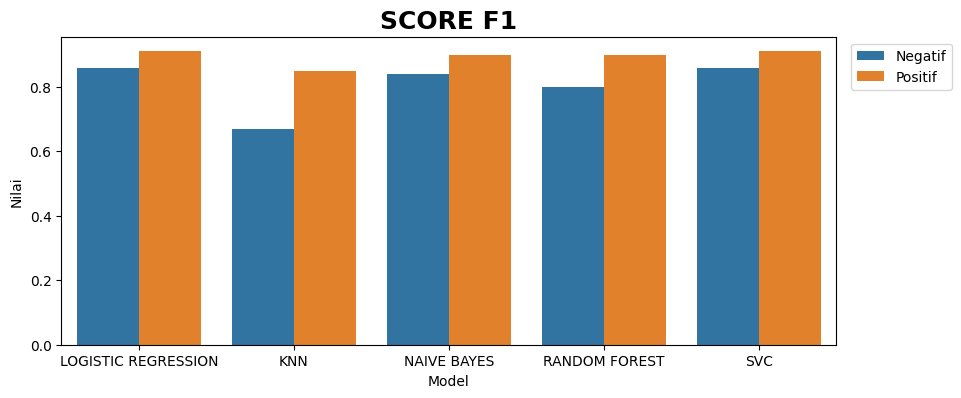

In [86]:
plt.figure(figsize= (10,4))
sns.barplot(
    data = f1_df.melt(id_vars="Model", var_name= "Score", value_name= "Nilai"),
    x = "Model",
    y = "Nilai",
    hue = "Score"
)
plt.legend(bbox_to_anchor = (1.01,1))
plt.title("SCORE F1", fontsize = 18, fontweight = "bold")

In [87]:
import joblib

joblib.dump(model_svc, "Model_SVC_1.pkl")

['Model_SVC_1.pkl']

In [82]:
joblib.dump(vectorizer, "vectorizer.pkl")

['vectorizer.pkl']

In [126]:
df_test = pd.read_csv("Prediksi LKS 2025 Survey Data_5.csv")
df_test

,Unnamed: 0,Survey,Clean_Text,Label
0,0,Dipertahankan,tahan,positif
1,1,Tidak ada udah sangat bagus,tidak ada sangat bagus,positif
2,2,Tetap semangat dan sabar dalam menyampaikan ma...,semangat sabar materi siswa semangat semangat,positif
3,3,untuk praktikum berikutnya diperbanyak menggun...,untuk praktikum banyak alat,negatif
4,4,Semoga kedepannya bisa lebih menjadi lebih bai...,moga depan baik ajar,positif
...,...,...,...,...
711,711,Semoga sehat selalu,moga sehat,positif
712,712,Memperbanyak latian soal dan mempraktikan lang...,banyak latian praktik alat fisik simulasi,negatif
713,713,Seharusnya diadakan ofline aja sih,ada offline sih,negatif
714,714,terimakasih bu atas ilmu yang diberikan,terimakasih bu ilmu yang,positif


In [127]:
df_prediksi = pd.read_csv("Prediksi LKS 2025 Survey Data_5.csv")
df_prediksi = df_prediksi['Label']
df_prediksi.head()

0    positif
1    positif
2    positif
3    negatif
4    positif
Name: Label, dtype: object

In [128]:
df_prediksi.to_csv("prediksi_eyak_52.csv")